# RAG with NVIDIA AI Playground

**NVIDIA AI Playground** on NGC allows developers to experience state of the art LLMs accelerated on NVIDIA DGX Cloud with NVIDIA TensorRT nd Triton Inference Server. Developers get **free credits for 10K requests** to any of the available models. Sign up process is easy. Follow the instructions <a href="https://github.com/NVIDIA/GenerativeAIExamples/blob/main/RetrievalAugmentedGeneration/docs/aiplayground.md"> here </a>

This notebook demonstrates how to use LangChain(https://python.langchain.com/docs/get_started/introduction) and NVIDIA AI Playground to build a chatbot that references a custom knowledge-base.

Suppose you have some text documents (PDF, blog, Notion pages, etc.) and want to ask questions related to the contents of those documents. LLMs, given their proficiency in understanding text, are a great tool for this.

![](https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/rag-pipeline-ingest-query-flow-b.png)

### Part I: Install all necessary packages

In [8]:
!pip install langchain==0.1.4 unstructured==0.12.2 unstructured[pdf]==0.12.2 fastapi==0.109.0 kaleido==0.2.1 uvicorn==0.27.0 sentence-transformers==2.2.2 chromadb==0.4.22 langchain-nvidia-ai-endpoints==0.0.1

  Using cached langchain-0.1.4-py3-none-any.whl (803 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

### Part II: Load Documents [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
LangChain provides a variety of [document loaders](https://python.langchain.com/docs/integrations/document_loaders) that load various types of documents (HTML, PDF, code) from many different sources and locations (private s3 buckets, public websites).

Document loaders load data from a source as **Documents**. A **Document** is a piece of text (the page_content) and associated metadata. Document loaders provide a ``load`` method for loading data as documents from a configured source.

In this example, we use a LangChain [`UnstructuredFileLoader`](https://python.langchain.com/docs/integrations/document_loaders/unstructured_file) to load a research paper about Llama2 from Meta.

[Here](https://python.langchain.com/docs/integrations/document_loaders) are some of the other document loaders available from LangChain.

In [11]:
!wget -O "ChipNeMo.pdf" -nc --user-agent="Mozilla" https://d1qx31qr3h6wln.cloudfront.net/publications/ChipNeMo%20%282%29.pdf

File ‘ChipNeMo.pdf’ already there; not retrieving.


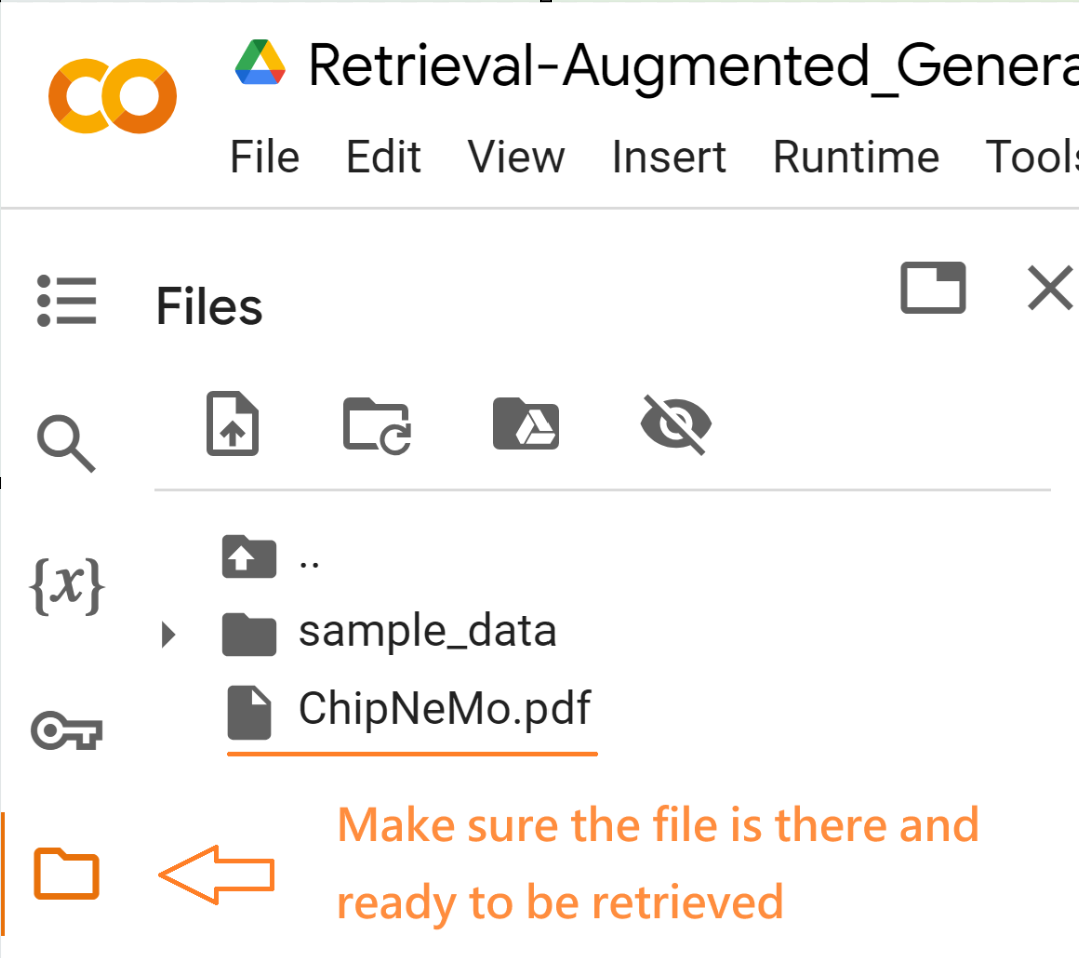

In [12]:
from langchain.document_loaders import UnstructuredFileLoader
loader = UnstructuredFileLoader("ChipNeMo.pdf")
data = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Step III: Transform Documents [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
Once documents have been loaded, they are often transformed. One method of transformation is known as **chunking**, which breaks down large pieces of text, for example, a long document, into smaller segments. This technique is valuable because it helps [optimize the relevance of the content returned from the vector database](https://www.pinecone.io/learn/chunking-strategies/).

LangChain provides a [variety of document transformers](https://python.langchain.com/docs/integrations/document_transformers/), such as text splitters. In this example, we use a [``SentenceTransformersTokenTextSplitter``](https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.SentenceTransformersTokenTextSplitter.html#langchain.text_splitter.SentenceTransformersTokenTextSplitter). The ``SentenceTransformersTokenTextSplitter`` is a specialized text splitter for use with the sentence-transformer models. The default behaviour is to split the text into chunks that fit the token window of the sentence transformer model that you would like to use. This sentence transformer model is used to generate the embeddings from documents.

There are some nuanced complexities to text splitting since semantically related text, in theory, should be kept together.

In [13]:
import time
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
TEXT_SPLITTER_MODEL = "intfloat/e5-large-v2"
TEXT_SPLITTER_CHUNCK_SIZE = 510
TEXT_SPLITTER_CHUNCK_OVERLAP = 200

text_splitter = SentenceTransformersTokenTextSplitter(
    model_name=TEXT_SPLITTER_MODEL,
    chunk_size=TEXT_SPLITTER_CHUNCK_SIZE,
    chunk_overlap=TEXT_SPLITTER_CHUNCK_OVERLAP,
)
start_time = time.time()
documents = text_splitter.split_documents(data)
print(f"--- {time.time() - start_time} seconds ---")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

handler.py:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

--- 3.115832805633545 seconds ---


### Part IV: Generate Embeddings and Store Embeddings in the Vector Store [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)

#### a) Generate Embeddings
[Embeddings](https://python.langchain.com/docs/modules/data_connection/text_embedding/) for documents are created by vectorizing the document text; this vectorization captures the semantic meaning of the text. This allows you to quickly and efficiently find other pieces of text that are similar. The embedding model used below is [intfloat/e5-large-v2](https://huggingface.co/intfloat/e5-large-v2).

LangChain provides a wide variety of [embedding models](https://python.langchain.com/docs/integrations/text_embedding) from many providers and makes it simple to swap out the models.

When a user sends in their query, the query is also embedded using the same embedding model that was used to embed the documents. As explained earlier, this allows to find similar (relevant) documents to the user's query.

#### b) Store Document Embeddings in the Vector Store
Once the document embeddings are generated, they are stored in a vector store so that at query time we can:
1) Embed the user query and
2) Retrieve the embedding vectors that are most similar to the embedding query.

A vector store takes care of storing the embedded data and performing a vector search.

LangChain provides support for a [great selection of vector stores](https://python.langchain.com/docs/integrations/vectorstores/).

<div class="alert alert-block alert-info">
    
⚠️ For this workflow, [chroma](https://www.trychroma.com/) is used for vector database (DB)

</div>

In [14]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
import torch
import time

#Running the model on CPU as we want to conserve gpu memory.
#In the production deployment (API server shown as part of the 5th notebook we run the model on GPU)
model_name = "intfloat/e5-large-v2"
model_kwargs = {"device": "cuda:0"}
encode_kwargs = {"normalize_embeddings": False}
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)
start_time = time.time()
vectorstore = Chroma.from_documents(documents, hf_embeddings)
print(f"--- {time.time() - start_time} seconds ---")

--- 8.508845329284668 seconds ---


### Part V: Sign up to NVIDIA AI Playground

Let's explore powerful Large Language Models (LLMs) on NVIDIA AI Playground. Sign up for free credits, follow the [**instructions**](https://github.com/Squirtle007/Retrieval-Augmented_Generation/blob/main/README.md), and try out the llama2 13B model in this example.

In [15]:
import os
from langchain_nvidia_ai_endpoints import ChatNVIDIA


from langchain.callbacks import streaming_stdout

os.environ['NVIDIA_API_KEY'] = "Paste Your API Key Here!!"

callbacks = [streaming_stdout.StreamingStdOutCallbackHandler()]

llm = ChatNVIDIA(model="mixtral_8x7b")

### Part VI: Ask a question without context

Send request to the llm without any context from the vector DB. The answer is generic and irrelvant.

In [20]:
question = "What is ChipNeMo?"
answer = llm.invoke(question)
answer.content

'Thank you for your thoughtful guidelines. I\'m happy to help!\n\nChipNeMo is not a widely recognized term or concept in the technology or chip-making industry. It is possible that it could be a specific term used within a certain company or project, but without more context, it\'s difficult for me to provide a precise definition.\n\nHowever, based on the individual words that make up the term, it could potentially refer to a "chip" (short for microchip or integrated circuit) that is related to "neuro" (short for neuroscience or neural networks) and "mo" (short for mobile or motion). So, one possible interpretation of ChipNeMo could be a mobile or motion-enabled chip designed for neuroscience or neural network applications.\n\nWithout further information, this is just a speculative interpretation, and I would recommend seeking clarification from the source that used the term to ensure an accurate understanding.'

### Step 6: Compose a streamed answer using a Chain
We have already integrated the Llama2 TRT LLM into LangChain with a custom wrapper, loaded and transformed documents, and generated and stored document embeddings in a vector database. To finish the pipeline, we need to add a few more LangChain components and combine all the components together with a [chain](https://python.langchain.com/docs/modules/chains/).

A [LangChain chain](https://python.langchain.com/docs/modules/chains/) combines components together. In this case, we use a [RetrievalQA chain](https://js.langchain.com/docs/modules/chains/popular/vector_db_qa/), which is a chain type for question-answering against a vector index. It combines a *Retriever* and a *question answering (QA) chain*.

We pass it 3 of our LangChain components:
- Our instance of the LLM (from step 1).
- A [retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/), which is an interface that returns documents given an unstructured query. In this case, we use our vector store as the retriever.
- Our prompt template constructed from the prompt format for Llama2 (from step 2)

```
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever(),
    chain_type_kwargs={"prompt": LLAMA_PROMPT}
)
```

Lastly, we pass a user query to the chain and stream the result.

In [18]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever()
)
result = qa_chain({"query": question})
result['result']

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
